<a href="https://colab.research.google.com/github/unipd-human-data/env-soundnet/blob/main/env-soundnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing

Installazione librerie e setup ambiente

In [3]:
!pip install librosa pydub torchaudio snntorch tqdm matplotlib seaborn torchinfo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 13.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [4]:
# Libreria standard
import os                               # file e cartelle
import numpy as np                      # operazioni matriciali, audio e spet sono matrici
import pandas as pd                     # leggere e gestire tabelle come esc50.csv
import matplotlib.pyplot as plt         # grafici std
import seaborn as sns                   # grafici statistici più belli

# Audio
import librosa                          # per audio in python, calcola features ecc
import librosa.display                  # visualizzare spettrogrammi
import torchaudio                       # audio di pytorch, usata per pipeline integrata con PyTorch
import torchaudio.transforms as T       # Moduli per convertire audio in MelSpectogram o trasfromazioni
from pydub import AudioSegment          # gestire audio a livello più "umano"

# Deep learning e SNN
import torch                            # costruzioni reti neurali
import snntorch as snn                  # estensione pytorch per SNN
import snntorch.functional as SF
from snntorch import spikegen           # converte input in spike train
from snntorch import spikeplot as splt
import tensorflow as tf                 # costruzione e training di modelli di ml e dl
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from torchinfo import summary

# Altri
from tqdm import tqdm                   # aggiungere barre di progresso ai loop, quanto manca al caricamento audio
from torch.utils.data import Dataset    # Dataset class
from torch.utils.data import DataLoader # DataLoader class
from enum import Enum
import time


In [5]:
print("GPU disponibile:", tf.config.list_physical_devices('GPU'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Userai:", device)

GPU disponibile: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Userai: cuda


Collegamento al drive

In [6]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Uploading CSV of ESC-50 metadata. Relocation of audio files in the ESC-50 and ESC-10 folders

In [7]:
esc_50_df = pd.read_csv("/content/drive/MyDrive/HumanData/ESC-50-master/meta/esc50.csv")

def relocate_files(file_name, category, is_esc10):
  src = f"/content/drive/MyDrive/HumanData/ESC-50-master/audio/{file_name}"
  esc50_dest_folder = f"/content/drive/MyDrive/HumanData/ESC-50/{category}"
  esc10_dest_folder = f"/content/drive/MyDrive/HumanData/ESC-10/{category}"

  # Ensure destination folder exists, creation folders
  os.makedirs(esc50_dest_folder, exist_ok=True)
  if is_esc10:
    os.makedirs(esc10_dest_folder, exist_ok=True)

  dest_esc50 = os.path.join(esc50_dest_folder, file_name)
  dest_esc10 = os.path.join(esc10_dest_folder, file_name)

  # Check if the file already exists in the destination
  if not os.path.exists(dest_esc50):
    shutil.copy(src, dest_esc50)
    print(f"Moved {file_name} to {dest_esc50}")
  else:
    print(f"File '{file_name}' already exists in '{dest_esc50}', skipping...")

  if not os.path.exists(dest_esc10):
    if is_esc10:
      shutil.copy(src, dest_esc10)
      print(f"Moved {file_name} to {dest_esc10}")
  else:
    print(f"File '{file_name}' already exists in '{dest_esc10}', skipping...")


#esc_50_df.apply(lambda row: relocate_files(row['filename'], row['category'], row['esc10']), axis = 1)


In [8]:
%ls /content/drive/MyDrive/HumanData/ESC-10/


chainsaw/    crackling_fire/  dog/         rain/     sea_waves/
clock_tick/  crying_baby/     helicopter/  rooster/  sneezing/


## Processare tutti i file audio di ESC10

In [9]:
BASE_PATH = '/content/drive/MyDrive/HumanData/ESC-10'
SAMPLE_RATE = 44100  # non fare downsampling
N_MELS = 128
N_FFT = 1024
HOP_LENGTH = 512
DURATION = 5.0       # lunghezza standard (secondi)
BATCH_SIZE = 32

class ESCLabels(Enum):
    chainsaw = 0
    clock_tick = 1
    crackling_fire = 2
    crying_baby = 3
    dog = 4
    helicopter = 5
    rain = 6
    rooster = 7
    sea_waves = 8
    sneezing = 9

- Se un audio ha una frequenza di campionamento di 44.1 kHz, significa che ogni secondo è rappresentato da 44.100 campioni (numeri). Più alta è la frequenza, più dettagliato sarà il suono (fino a un certo limite). 44.1 kHz è sufficiente per rappresentare tutte le frequenze udibili dall’orecchio umano (fino a ~20 kHz), secondo il teorema di Nyquist.

- Trim + Normalizzazione: rimuovo silenzio per non sprecare tempo computazionale su dati inutili. Scalare il segnale in [-1,1] in modo da rimuovere il bias di ampiezza tra clip (evita che la rete impari "volume=classe")

- Con la normalizzazione vado a modificare il range dell'ampiezza, cioè quanto forte o debole è il segnale

per ora non trimmo i silenzio --> possibile ablation study con e senza trim

Perché NON usare trim:
Mantieni la coerenza temporale tra le clip
→ fondamentale per SNN e spike encoding, che sono sensibili alla sequenza temporale dei pattern.

Eviti disallineamenti introdotti da librosa.effects.trim
→ anche 0.2 secondi di shift possono alterare l’input percepito dal modello.

Se usi segmenti (chunk) fissi via timesteps=50,
→ i segmenti devono sempre partire dallo stesso punto temporale.

In [10]:
def load_audio_file(file_path, sr=SAMPLE_RATE, duration=5.0, top_db = 30):
    y, sr = librosa.load(file_path, sr=sr, duration=duration)
    #y, _ = librosa.effects.trim(y, top_db=top_db)           # elimina silence iniziale e finale
    y = librosa.util.normalize(y)           # normalizzazione RMS
    #if len(y) < int(sr * duration):
    #    padding = int(sr * duration) - len(y)
    #    y = np.pad(y, (0, padding))         # padding se troppo corto
    return y

controllo di quanto silenzio toglie

In [11]:
# total_trimmed_start = 0.0
# total_trimmed_end = 0.0
# clip_count = 0

# for label in sorted(os.listdir(BASE_PATH)):
#     class_path = os.path.join(BASE_PATH, label)
#     for file in os.listdir(class_path):
#         if file.endswith(".wav"):
#             file_path = os.path.join(class_path, file)

#             # Carica audio
#             y, sr = librosa.load(file_path, sr=44100, duration=5.0)

#             # Applica trim
#             y_trimmed, index = librosa.effects.trim(y, top_db=30)
#             start_sample, end_sample = index

#             # Converti in secondi
#             start_sec = start_sample / sr
#             end_sec = (len(y) - end_sample) / sr

#             total_trimmed_start += start_sec
#             total_trimmed_end += end_sec
#             clip_count += 1

#             print(f"{file} → Trim: start={start_sec:.2f}s, end={end_sec:.2f}s")

# # Statistiche finali
# print("\n--- STATISTICHE TOTALI ---")
# print(f"Clip analizzati: {clip_count}")
# print(f"Silenzio medio INIZIALE tagliato: {total_trimmed_start / clip_count:.2f} s")
# print(f"Silenzio medio FINALE tagliato: {total_trimmed_end / clip_count:.2f} s")


In [12]:
X_audio = []
y_labels = []
labels = sorted(os.listdir(BASE_PATH))  # lista classi ordinate
print(labels, "\n")
label_to_index = {label: idx for idx, label in enumerate(labels)}

for label in tqdm(labels, desc="Caricamento Audio"):
    class_path = os.path.join(BASE_PATH, label)
    for file in os.listdir(class_path):
        if file.endswith('.wav'):
            file_path = os.path.join(class_path, file)
            y = load_audio_file(file_path, sr=SAMPLE_RATE, duration=DURATION)
            X_audio.append(y)
            y_labels.append(label_to_index[label])

['chainsaw', 'clock_tick', 'crackling_fire', 'crying_baby', 'dog', 'helicopter', 'rain', 'rooster', 'sea_waves', 'sneezing'] 



Caricamento Audio: 100%|██████████| 10/10 [05:35<00:00, 33.53s/it]


In [13]:
X_train, X_temp, y_train, y_temp = train_test_split(X_audio, y_labels, test_size=0.4, random_state=42, stratify=y_labels)

# Poi dividi temp in val e test (50/50 => 15% ciascuno)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 240, Val: 80, Test: 80


## NAA

In [14]:
def center_crop(signal, target_len):
    if len(signal) < target_len:
        pad_left = (target_len - len(signal)) // 2
        pad_right = target_len - len(signal) - pad_left
        return np.pad(signal, (pad_left, pad_right), mode='constant')
    else:
        start = (len(signal) - target_len) // 2
        return signal[start:start + target_len]


In [15]:
def naa(y, sr):
    augmented = []
    target_len = int(sr * 5.0)

    # Originale
    augmented.append(center_crop(y, target_len))

    # Pitch shift
    augmented.append(center_crop(librosa.effects.pitch_shift(y, sr=sr, n_steps=+2), target_len))
    augmented.append(center_crop(librosa.effects.pitch_shift(y, sr=sr, n_steps=-2), target_len))

    # Time stretch
    for rate in [0.7, 1.2]:
        y_stretched = librosa.effects.time_stretch(y, rate=rate)
        augmented.append(center_crop(y_stretched, target_len))

    return augmented


In [16]:

X_train_aug = []
y_train_aug = []

for i in tqdm(range(len(X_train)), desc="NAA"):
    original_audio = X_train[i]
    label = y_train[i]

    # Applica la tua funzione naa → restituisce 5 versioni (incluso l'originale)
    augmented_audios = naa(original_audio, sr=SAMPLE_RATE)

    # Aggiungi tutte le versioni alla lista finale
    X_train_aug.extend(augmented_audios)
    y_train_aug.extend([label] * len(augmented_audios))


NAA: 100%|██████████| 240/240 [01:03<00:00,  3.79it/s]


In [17]:

# Calcola le lunghezze di tutti gli audio
lengths = [len(x) for x in X_train_aug]

# Trova il minimo e il massimo
min_len = min(lengths)
max_len = max(lengths)

# Converti in secondi (facoltativo)
min_sec = min_len / SAMPLE_RATE
max_sec = max_len / SAMPLE_RATE

print(f"Audio più corto: {min_len} samples ({min_sec:.2f} s)")
print(f"Audio più lungo: {max_len} samples ({max_sec:.2f} s)")


Audio più corto: 220500 samples (5.00 s)
Audio più lungo: 220500 samples (5.00 s)


## Converti in log-Mel

- power_to_db(..., ref=np.max) normalizza ogni spettrogramma rispetto al suo massimo → rende il contrasto tra le bande più utile per la rete. Misura quanto ogni frequenza è forte rispetto al picco. Ha senso np.max perchè ho già normalizzato l'audio a [-1,1] quindi non hai una loudness assoluta. Per la classificazione di suoni ambientali il pattern spettrale è più importante del volume, voglio che ogni clip sia trattato in modo coerente (garantisce scale relative)

- power_to_db(..., ref=np.max) converte il Mel-spectrogramma da potenza lineare (espressa in unità numeriche) a decibel (scala logaritmica)

- il risultato più intenso avrà valore 0 dB. -80 invece significa “tutto ciò che è almeno 10⁸ volte più debole del valore massimo, consideralo praticamente silenzio”. La scala è negativa perchè stai calcolando il logaritmo del rapporto tra ogni valore del Mel-spect e il valore massimo di quel mel-spect



In [18]:
def preprocess_audio(y, sr=SAMPLE_RATE, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH):
  #Calcolare Mel-spectrogram
  y_mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
  #Convertire in Log
  y_mel = librosa.power_to_db(y_mel, ref=np.max)    #calcola i db rispetto al valore massimo nel Mel-spect.

  return y_mel


Clipping dei frame troppo silenziosi

In [19]:
def clip_silent_frames(mel, threshold_db=-70.0):
    silent_mask = np.all(mel < threshold_db, axis=0)
    mel[:, silent_mask] = threshold_db  # o np.mean(mel)
    return mel

In [20]:
def batch_logmel(X, sr=SAMPLE_RATE):
    mel_list = []
    for x in tqdm(X, desc="Log-Mel"):
        mel = preprocess_audio(x, sr=sr)
        # mel = clip_silent_frames(mel)
        mel_list.append(mel)
    return mel_list

In [21]:
X_train_mel = batch_logmel(X_train_aug)
X_val_mel = batch_logmel(X_val)
X_test_mel = batch_logmel(X_test)

# X_train_mel = batch_logmel(X_train)
# X_val_mel = batch_logmel(X_val)
# X_test_mel = batch_logmel(X_test)

Log-Mel: 100%|██████████| 80/80 [00:00<00:00, 113.58it/s]


In [22]:
print("Train set:", len(X_train_mel))
print("Val set:", len(X_val_mel))
print("Test set:", len(X_test_mel))

print("Shape primo sample train:", X_train_mel[0].shape)

Train set: 1200
Val set: 80
Test set: 80
Shape primo sample train: (128, 431)


visualizzo logmel spect

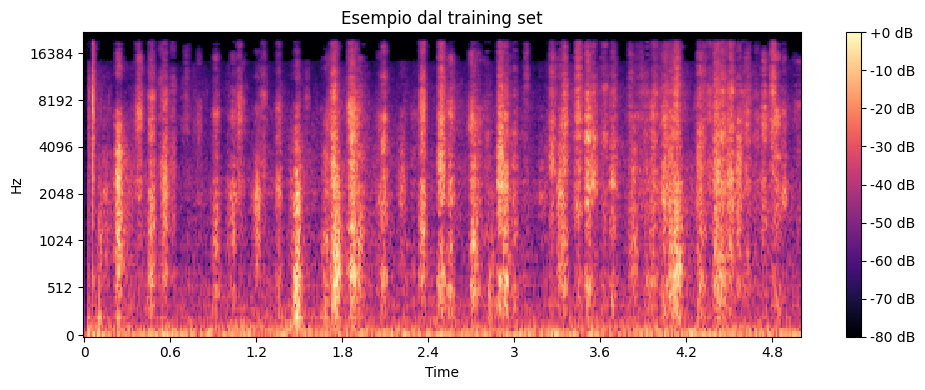

Class:  sea_waves


In [23]:
def show_mel(mel, title="Log-Mel Spectrogram"):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel, sr=SAMPLE_RATE, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Visualizza un esempio a caso dal training set
sample_idx = 32
show_mel(X_train_mel[sample_idx], title="Esempio dal training set")
print("Class: ", ESCLabels(y_train[sample_idx]).name)


In [24]:
all_vals = np.concatenate([mel.flatten() for mel in X_train_mel])
print("Min:", np.min(all_vals))
print("Max:", np.max(all_vals))

Min: -80.0
Max: 0.0


Padding per uniformare a 450

In [25]:
def pad_to_multiple_of(mel, multiple=50, value=-80.0):
    # Pads mel spectrogram along time axis to make time frames a multiple of 'multiple'
    current_len = mel.shape[1]
    target_len = ((current_len + multiple - 1) // multiple) * multiple
    pad_width = target_len - current_len
    return np.pad(mel, ((0, 0), (0, pad_width)), mode='constant', constant_values=value)


In [26]:
# Applica padding a multiplo di 50 (compatibile con timesteps=50)
X_train_mel = [pad_to_multiple_of(mel, multiple=50) for mel in X_train_mel]
X_val_mel = [pad_to_multiple_of(mel, multiple=50) for mel in X_val_mel]
X_test_mel = [pad_to_multiple_of(mel, multiple=50) for mel in X_test_mel]

In [27]:
print("Train shape esempio:", X_train_mel[0].shape)
print("Val shape esempio:", X_val_mel[0].shape)
print("Test shape esempio:", X_test_mel[0].shape)

Train shape esempio: (128, 450)
Val shape esempio: (128, 450)
Test shape esempio: (128, 450)


## DATA AUG TAA

applicare taa dopo normalizzazione perchè imagedatagenerator lavora bene su [0,1]

In [28]:
"""
taa_generator = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.25,
    shear_range=0.3,
    fill_mode='nearest'
)
"""

"\ntaa_generator = ImageDataGenerator(\n    width_shift_range=0.2,\n    height_shift_range=0.2,\n    zoom_range=0.25,\n    shear_range=0.3,\n    fill_mode='nearest'\n)\n"

In [29]:
X_train_mel_np = np.array(X_train_mel)
X_val_mel_np = np.array(X_val_mel)
X_test_mel_np = np.array(X_test_mel)

if len(X_train_mel_np.shape) == 3:
    X_train_mel_np = X_train_mel_np[..., np.newaxis]  # (N, 64, 431, 1)

y_train_np = np.array(y_train_aug)  # Etichette corrispondenti
#y_train_np = np.array(y_train)

### Normalizzazione:
i modelli funzionano meglio con input compresi tra 0 e 1.
0 = silenzio
1 = banda più forte

In [30]:
X_train_mel_np = (X_train_mel_np + 80.0) / 80.0
X_val_mel_np = (X_val_mel_np + 80.0) / 80.0
X_test_mel_np = (X_test_mel_np + 80.0) / 80.0

### TAA

In [31]:
"""
X_taa = []
y_taa = []

augmentations_per_sample = 4  # puoi aumentare questo numero

for i in tqdm(range(len(X_train_mel_np)), desc="TAA Augmentation"):
    sample = X_train_mel_np[i]  # shape: (64, max_len, 1)
    sample = np.expand_dims(sample, axis=0)  # shape: (1, 64, max_len, 1)

    # Genera augmentazioni
    gen = taa_generator.flow(sample, batch_size=1)
    for _ in range(augmentations_per_sample):
        aug_sample = next(gen)[0]  # shape: (64, max_len, 1)
        X_taa.append(aug_sample)
        y_taa.append(y_train_np[i])

# Combina con il training set originale
X_train_augmented = np.concatenate([X_train_mel_np, np.array(X_taa)], axis=0)
y_train_augmented = np.concatenate([y_train_np, np.array(y_taa)], axis=0)

print("Nuova shape X:", X_train_augmented.shape)
print("Nuova shape y:", y_train_augmented.shape)
"""

'\nX_taa = []\ny_taa = []\n\naugmentations_per_sample = 4  # puoi aumentare questo numero\n\nfor i in tqdm(range(len(X_train_mel_np)), desc="TAA Augmentation"):\n    sample = X_train_mel_np[i]  # shape: (64, max_len, 1)\n    sample = np.expand_dims(sample, axis=0)  # shape: (1, 64, max_len, 1)\n\n    # Genera augmentazioni\n    gen = taa_generator.flow(sample, batch_size=1)\n    for _ in range(augmentations_per_sample):\n        aug_sample = next(gen)[0]  # shape: (64, max_len, 1)\n        X_taa.append(aug_sample)\n        y_taa.append(y_train_np[i])\n\n# Combina con il training set originale\nX_train_augmented = np.concatenate([X_train_mel_np, np.array(X_taa)], axis=0)\ny_train_augmented = np.concatenate([y_train_np, np.array(y_taa)], axis=0)\n\nprint("Nuova shape X:", X_train_augmented.shape)\nprint("Nuova shape y:", y_train_augmented.shape)\n'

Converto in tensori

In [32]:
"""
X_train = torch.from_numpy(X_train_augmented).float()
X_val = torch.from_numpy(X_val_mel_np).float()
X_test = torch.from_numpy(X_test_mel_np).float()
y_train = torch.from_numpy(y_train_augmented).long()
y_val = torch.from_numpy(np.array(y_val)).long()
y_test = torch.from_numpy(np.array(y_test)).long()
"""

X_train = torch.from_numpy(X_train_mel_np).float()
X_val = torch.from_numpy(X_val_mel_np).float()
X_test = torch.from_numpy(X_test_mel_np).float()
y_train = torch.from_numpy(y_train_np).long()
y_val = torch.from_numpy(np.array(y_val)).long()
y_test = torch.from_numpy(np.array(y_test)).long()

In [33]:
print("Shape X_train:", X_train.shape)
print("Tipo dati:", X_train.dtype)
print("Valori min/max:", torch.min(X_train), torch.max(X_train))


Shape X_train: torch.Size([1200, 128, 450, 1])
Tipo dati: torch.float32
Valori min/max: tensor(0.) tensor(1.)


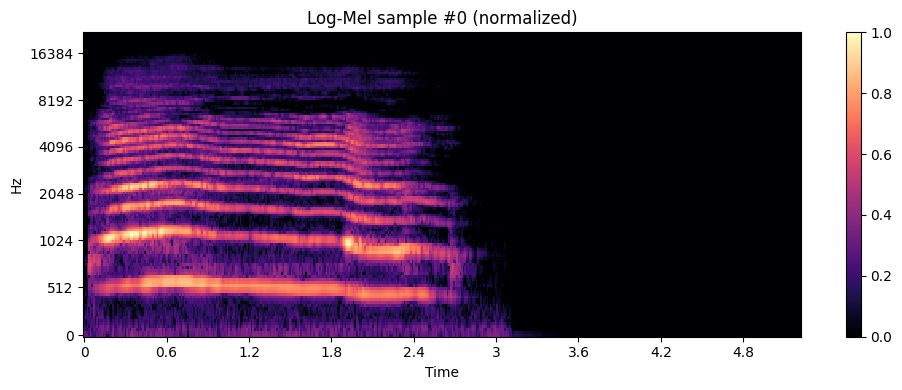

Class: crying_baby


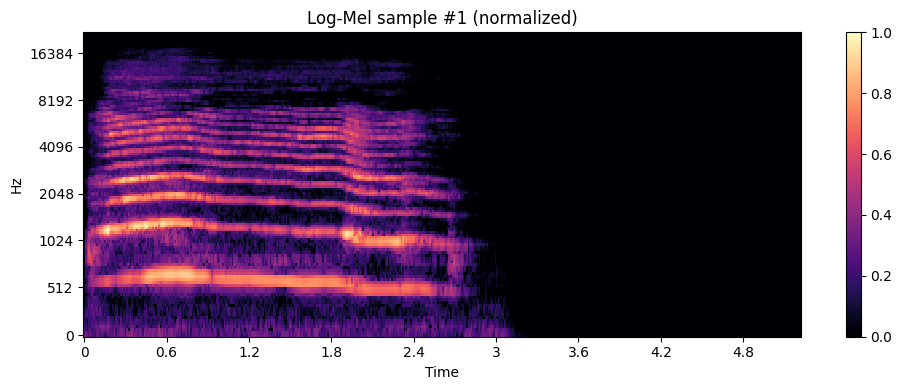

Class: crying_baby


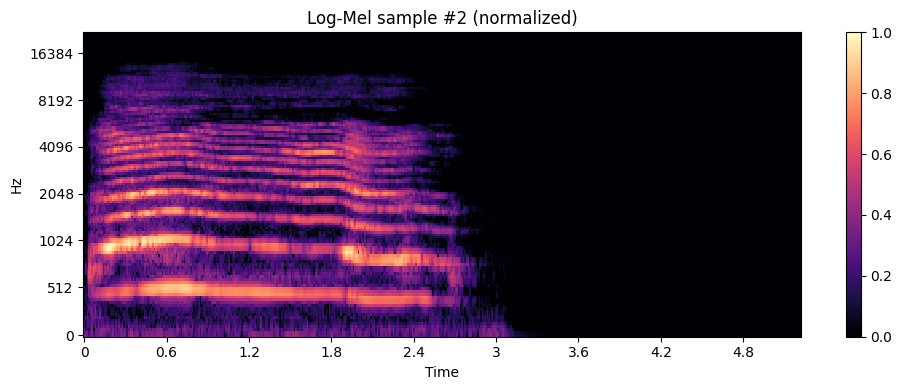

Class: crying_baby


In [34]:
def show_mel_sample(index):
    mel = X_train[index].numpy().squeeze()  # converti tensore in NumPy
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel, sr=SAMPLE_RATE, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel')
    plt.colorbar()  # non usare '%+2.0f dB' perché ora i valori sono [0, 1]
    plt.title(f"Log-Mel sample #{index} (normalized)")
    plt.tight_layout()
    plt.show()
    print("Class:", ESCLabels(y_train[index].item()).name)

for i in range(3):
    show_mel_sample(i)

In [35]:
print("y_train shape:", y_train.shape)
print("Etichette uniche:", np.unique(y_train))

# Stampa etichetta di un esempio
for i in range(3):
    print(f"Esempio {i}: label = {y_train[i]}")


y_train shape: torch.Size([1200])
Etichette uniche: [0 1 2 3 4 5 6 7 8 9]
Esempio 0: label = 3
Esempio 1: label = 3
Esempio 2: label = 3


# Spike Encoding

We define now an helper function to visualize the following ecoded spike trains.

In [36]:
def visualize_spike_trains(spike_tensor, sample_idx=0, mel_bin=10):
    """
    Visualizes delta spike encodings with three plots:
    1. Full raster plot of all mel bins
    2. Single mel bin spike train with vertical lines
    3. Density plot showing balance between positive and negative spikes

    Args:
      spike_tensor : torch.Tensor or list
          The delta spike tensor. Expected shape: [batch_size, time_frames, n_mels]
          If from DataLoader, expected to be a list containing tensors
      sample_idx : int
          Index of the sample in the batch to visualize
      mel_bin : int
          Which mel frequency bin to visualize in the spike train plot
    """

    # Check if input is a list (from DataLoader) or direct tensor
    if isinstance(spike_tensor, list):
        spikes = spike_tensor[0].squeeze(-1)[sample_idx].detach().cpu().numpy()
    elif isinstance(spike_tensor, torch.Tensor):
        # If 4D tensor [batch_size, time_frames, n_mels]
        if len(spike_tensor.shape) == 3:
            spikes = spike_tensor.squeeze(-1)[sample_idx, :, :].detach().cpu().numpy()
        else:
            raise ValueError(f"Unexpected spike tensor shape: {spike_tensor.shape}")
    else:
        raise TypeError("spike_tensor must be a torch.Tensor or a list containing tensors")

    if len(spikes.shape) > 2:
        spikes = spikes.squeeze()

    pos_spikes = (spikes > 0).astype(float)
    neg_spikes = (spikes < 0).astype(float)

    plt.figure(figsize=(10, 12))

    # 1. Raster Plot with Inverted Y-axis
    plt.subplot(3, 1, 1)
    plt.imshow(spikes.T, aspect='auto', cmap='coolwarm', vmin=-1, vmax=1, origin='lower')
    plt.colorbar(ticks=[-1, 0, 1], label='Spike Type')
    plt.title("Full Raster Plot")
    plt.xlabel("Time Step")
    plt.ylabel("Mel Bin")
    num_mel_bins = spikes.shape[1]
    tick_interval = max(1, num_mel_bins // 7)
    plt.yticks(np.arange(0, num_mel_bins, tick_interval))

    # 2. Single Mel Bin Spike Train with vlines
    plt.subplot(3, 1, 2)
    pos_times = np.where(spikes[:, mel_bin] == 1)[0]
    neg_times = np.where(spikes[:, mel_bin] == -1)[0]
    plt.vlines(pos_times, 0, 1, color='red', linewidth=0.8)
    plt.vlines(neg_times, -1, 0, color='blue', linewidth=0.8)
    plt.yticks([-1, 0, 1])
    plt.ylim(-1.2, 1.2)
    plt.title(f"Spike Train for Mel Bin {mel_bin}")
    plt.xlabel("Time Step")
    plt.ylabel("Spike Value")
    plt.grid(False)
    legend_elements = [plt.Line2D([0], [0], color='red', lw=2, label='Positive Spikes'),
                      plt.Line2D([0], [0], color='blue', lw=2, label='Negative Spikes')]
    plt.legend(handles=legend_elements)

    # 3. Density Plot with Legend
    plt.subplot(3, 1, 3)
    plt.stackplot(np.arange(spikes.shape[0]),
                  pos_spikes.sum(axis=1),
                  -neg_spikes.sum(axis=1),
                  colors=['red', 'blue'])

    plt.legend(['Positive Spikes', 'Negative Spikes'])
    plt.title("Spike Polarity Balance Over Time")
    plt.xlabel("Time Step")
    plt.ylabel("Net Spike Count")

    plt.tight_layout()
    plt.show()

## Delta Modulation

Delta modulation converts time-series tensors into spike trains by looking at the difference between pair of subsequent values.

By default, if the difference is both *positive* and *greater than a predefined threshold* $V_{\text{thr}}$, a spike is generated.
However, this type of encoding does not account for large negative peaks in the signal, leading to a possible loss of information in the encoding. For this reason, we consider also negative spikes (or *off-spikes*), that are generated when the difference between subsequent values is both *negative* and *greater than the threshold* $V_{\text{thr}}$ *in absolute value*.

Mathematically, given an input sequence $x[t], t=1,\dots,T$, where $T$ denotes the number of time steps, and a *positive* threshold $V_{\text{thr}}$, the spike encoding with delta modulation is obtained as:
$$
S[t] =
\begin{cases}
\, 1 \qquad \text{if}\;\; x[t+1]-x[t] > V_{\text{thr}}\\
-1 \;\,\quad \text{if}\;\; x[t+1]-x[t] < -V_{\text{thr}}\\
\, 0 \qquad \text{otherwise.}
\end{cases}
$$



Due to the high dimensionality of the input data, feeding it directly into the model significantly slows down training. To mitigate this, I implemented an aggregation process within the \_\_getitem\_\_() function. This process divides the spectrogram along the time axis into fixed-size chunks and computes the mean across the time frames within each chunk, effectively reducing the temporal resolution and improving training efficiency.



In [37]:
class DeltaAudioDataset(Dataset):
    def __init__(self, X, y, threshold=0.05, timesteps=10, off_spike=True):
        """
        X: Tensor of shape [num_samples, n_mels, time_steps, 1]
        y: Tensor of shape [num_samples]
        """
        self.X = X
        self.y = y
        self.timesteps = timesteps
        self.threshold = threshold
        self.off_spike = off_spike

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx].squeeze(-1)  # [n_mels, time_steps]
        y = self.y[idx]

        chunks = torch.tensor_split(x, self.timesteps, dim=-1)

        x_chunks = torch.stack(
            [window.mean(dim=-1) for window in chunks], dim=0
        )

        # Apply delta modulation (shape stays [time_steps, n_mels])
        spike_train = spikegen.delta(
            x_chunks, threshold=self.threshold, off_spike=self.off_spike
        )

        return spike_train, y.long()

In [38]:
# Datasets
train_dataset = DeltaAudioDataset(
    X_train,
    y_train,
    threshold=0.05,
    timesteps=200
)
val_dataset = DeltaAudioDataset(
    X_val,
    y_val,
    threshold=0.05,
    timesteps=200
)
test_dataset = DeltaAudioDataset(
    X_test,
    y_test,
    threshold=0.05,
    timesteps=200
)

# Data Loaders
delta_train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers = 2,
    pin_memory=torch.cuda.is_available()
)
delta_val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers = 2,
    pin_memory=torch.cuda.is_available()
)
delta_test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers = 2,
    pin_memory=torch.cuda.is_available()
)

X_batch, y_batch = next(iter(delta_train_dataloader))
print("DeltaModulation encoding compleated!")

DeltaModulation encoding compleated!


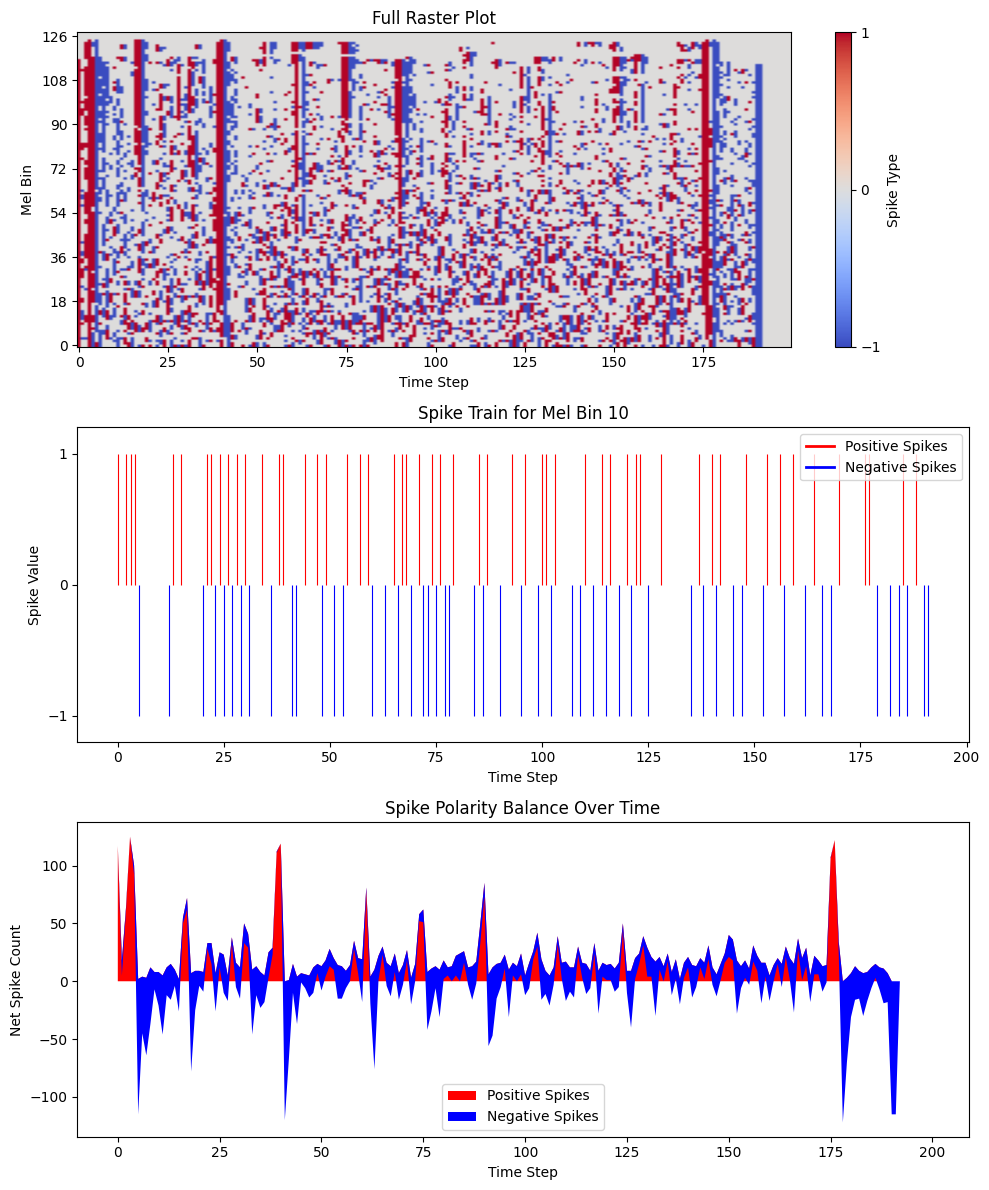

Class crackling_fire


In [39]:
sample_idx = 2
visualize_spike_trains(X_batch, sample_idx=sample_idx, mel_bin=10)
print("Class", ESCLabels(y_batch[sample_idx].item()).name)

Identificazione dei frame silenziosi nei log-mel

In [40]:
def count_silent_frames(mel_list, silence_threshold_db=-70):
    silent_frame_counts = []
    for mel in tqdm(mel_list, desc="Analisi dei frame silenziosi"):
        # Conta i frame in cui tutti i valori sono inferiori alla soglia di silenzio
        silent_frames = np.all(mel < silence_threshold_db, axis=0)
        silent_frame_counts.append(np.sum(silent_frames))
    return silent_frame_counts

In [41]:
silent_counts_train = count_silent_frames(X_train_mel)
silent_counts_val = count_silent_frames(X_val_mel)
silent_counts_test = count_silent_frames(X_test_mel)

print(f"\nMedia dei frame silenziosi nel training set: {np.mean(silent_counts_train):.2f}")
print(f"Media dei frame silenziosi nel validation set: {np.mean(silent_counts_val):.2f}")
print(f"Media dei frame silenziosi nel test set: {np.mean(silent_counts_test):.2f}")


Analisi dei frame silenziosi: 100%|██████████| 80/80 [00:00<00:00, 11773.90it/s]


Media dei frame silenziosi nel training set: 85.99
Media dei frame silenziosi nel validation set: 71.09
Media dei frame silenziosi nel test set: 72.64


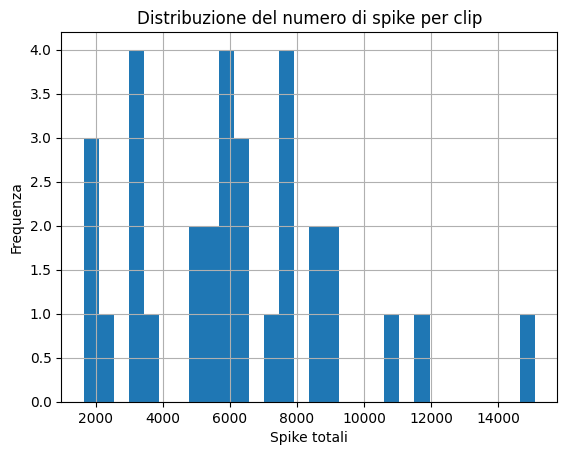

In [42]:
def count_spikes(spike_train):
    return spike_train.abs().sum(dim=[1, 2])  # somma spike su tempo e bande mel

spike_counts = count_spikes(X_batch)
plt.hist(spike_counts.cpu().numpy(), bins=30)
plt.title("Distribuzione del numero di spike per clip")
plt.xlabel("Spike totali")
plt.ylabel("Frequenza")
plt.grid(True)
plt.show()


## Moving Window

In [43]:
class MovingWindowDataset(Dataset):
  def __init__(self, X, y, window_length=10):
    """
      Moving Window encoding dataset for audio spectrograms.

      Args:
          X: Tensor of shape [num_samples, n_mels, time_steps, 1]
          y: Tensor of labels [num_samples]
          window_length: Size of the sliding window for calculating the base mean
    """
    self.X = X
    self.y = y
    self.window_length = window_length

  def __len__(self):
    return len(self.X)

  def _encode(self, signal, k=3.0):
    """
    Ternary spike encoder using the Moving Window method (Algorithm 3 compliant).

    Args:
        signal: 1D tensor to encode
        k: Multiplier for threshold sensitivity (higher = sparser spike train)

    Returns:
        Encoded spike train with values in {-1, 0, 1}
    """
    signal_np = signal.numpy()
    spikes = np.zeros_like(signal_np, dtype=np.float32)

    # Compute variation-based threshold
    variation = np.diff(signal_np, prepend=signal_np[0])
    threshold = k * np.mean(np.abs(variation))

    L = len(signal_np)
    w = self.window_length

    # Initial fixed baseline for first window+1 samples
    initial_base = np.mean(signal_np[: w + 1])

    for t in range(w + 1):  # Corresponds to t = 0 to w (inclusive)
        if signal_np[t] > initial_base + threshold:
            spikes[t] = 1
        elif signal_np[t] < initial_base - threshold:
            spikes[t] = -1

    # Moving window encoding for the rest
    for t in range(w + 1, L):  # Corresponds to t = w+1 to end
        base = np.mean(signal_np[t - w - 1 : t])  # match paper's s(t-w-1:t-1)

        if signal_np[t] > base + threshold:
            spikes[t] = 1
        elif signal_np[t] < base - threshold:
            spikes[t] = -1

    return torch.from_numpy(spikes)

  def __getitem__(self, idx):
    x = self.X[idx].squeeze(-1)  # [n_mels, time_steps]
    y = self.y[idx]

    spike_train = torch.zeros(
        x.shape[1], x.shape[0], dtype=torch.float32
    )  # [time_steps, n_mels]

    for mel_idx in range(x.shape[0]):
      spike_train[:, mel_idx] = self._encode(x[mel_idx])

    return spike_train.float(), y.long()

In [44]:
WINDOW_LENGTH = 1

mw_train_dataset = MovingWindowDataset(
    X_train, y_train,
    window_length=WINDOW_LENGTH
)

mw_val_dataset = MovingWindowDataset(
    X_val, y_val,
    window_length=WINDOW_LENGTH
)

mw_test_dataset = MovingWindowDataset(
    X_test, y_test,
    window_length=WINDOW_LENGTH
)

# Create dataloaders
mw_train_dataloader = DataLoader(
    dataset=mw_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=torch.cuda.is_available()
)

mw_val_dataloader = DataLoader(
    dataset=mw_val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=torch.cuda.is_available()
)

mw_test_dataloader = DataLoader(
    dataset=mw_test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=torch.cuda.is_available()
)

mw_x_batch, mw_y_batch = next(iter(mw_train_dataloader))

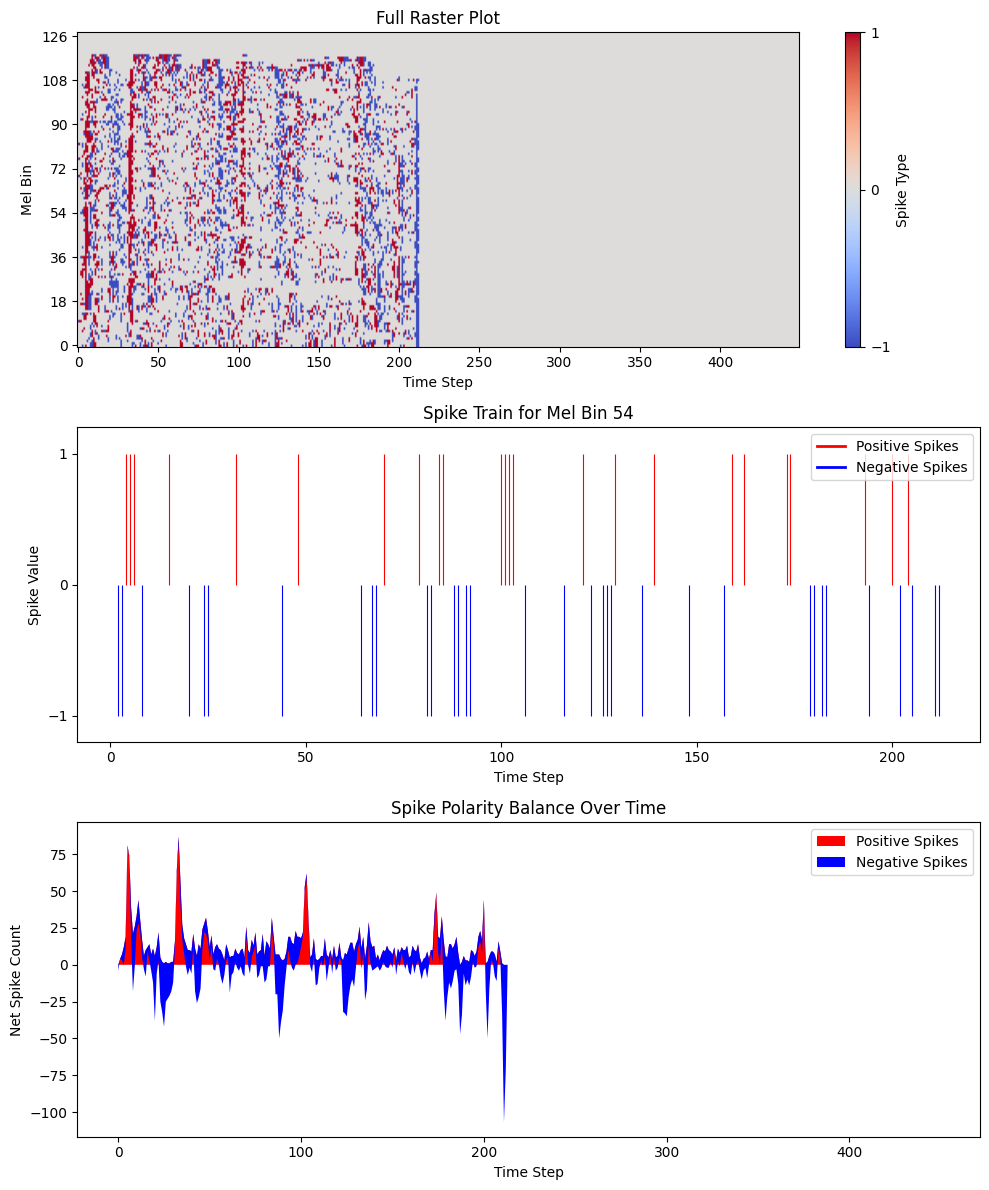

In [45]:
sample_idx = 0
visualize_spike_trains(spike_tensor=mw_x_batch, sample_idx=sample_idx, mel_bin=54)

## Threshold Adaptive Encoding

In [48]:
class ThresholdAdaptiveEncoding(Dataset):

  def __init__(self, X, y, alpha=0.9, threshold=0.05):
    self.X = X
    self.y = y
    self.alpha = alpha
    self.threshold = threshold

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    x = self.X[idx].squeeze(-1)  # [n_mels, time_steps]
    y = self.y[idx]

    spike_train = torch.zeros(
        x.shape[1], x.shape[0], dtype=torch.int8
    )  # [time_steps, n_mels]

    for mel_idx in range(x.shape[0]):
      spike_train[:, mel_idx] = self._encode_tae(x[mel_idx])

    return spike_train, y.long()

  def _encode_tae(self, signal):
    """
    Encode a signal using the Threshold Adaptive Encoding (TAE) algorithm.

    Args:
        signal: 1D tensor or 2D tensor of shape [1, N]

    Returns:
        1D tensor of encoded spikes with values in {-1, 0, 1}
    """
    if signal.dim() == 2:
        signal = signal.squeeze(0)  # ensure shape [N]

    signal_np = signal.numpy()
    spikes = np.zeros_like(signal_np, dtype=np.int8)

    base = signal_np[0]
    threshold = self.threshold  # use instance value
    alpha = self.alpha          # decay factor

    for i in range(1, len(signal_np)):
        diff = signal_np[i] - base
        if diff >= threshold:
            spikes[i] = 1
            base += threshold
            threshold *= alpha
        elif diff <= -threshold:
            spikes[i] = -1
            base -= threshold
            threshold *= alpha
        else:
            threshold *= alpha

    return torch.from_numpy(spikes)



In [57]:
ALPHA = 1.0

tae_train_dataset = ThresholdAdaptiveEncoding(
    X_train, y_train,
    alpha=ALPHA
)

tae_val_dataset = ThresholdAdaptiveEncoding(
    X_val, y_val,
    alpha=ALPHA
)

tae_test_dataset = ThresholdAdaptiveEncoding(
    X_test, y_test,
    alpha=ALPHA
)

# Create TAE dataloaders
tae_train_dataloader = DataLoader(
    dataset=tae_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=torch.cuda.is_available()
)

tae_val_dataloader = DataLoader(
    dataset=tae_val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=torch.cuda.is_available()
)

tae_test_dataloader = DataLoader(
    dataset=tae_test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=torch.cuda.is_available()
)

# Test the TAE encoding
print("Testing Threshold Adaptive Encoding...")
tae_x_batch, tae_y_batch = next(iter(tae_train_dataloader))
print(f"TAE batch shape: {tae_x_batch.shape}")


Testing Threshold Adaptive Encoding...
TAE batch shape: torch.Size([32, 450, 128])


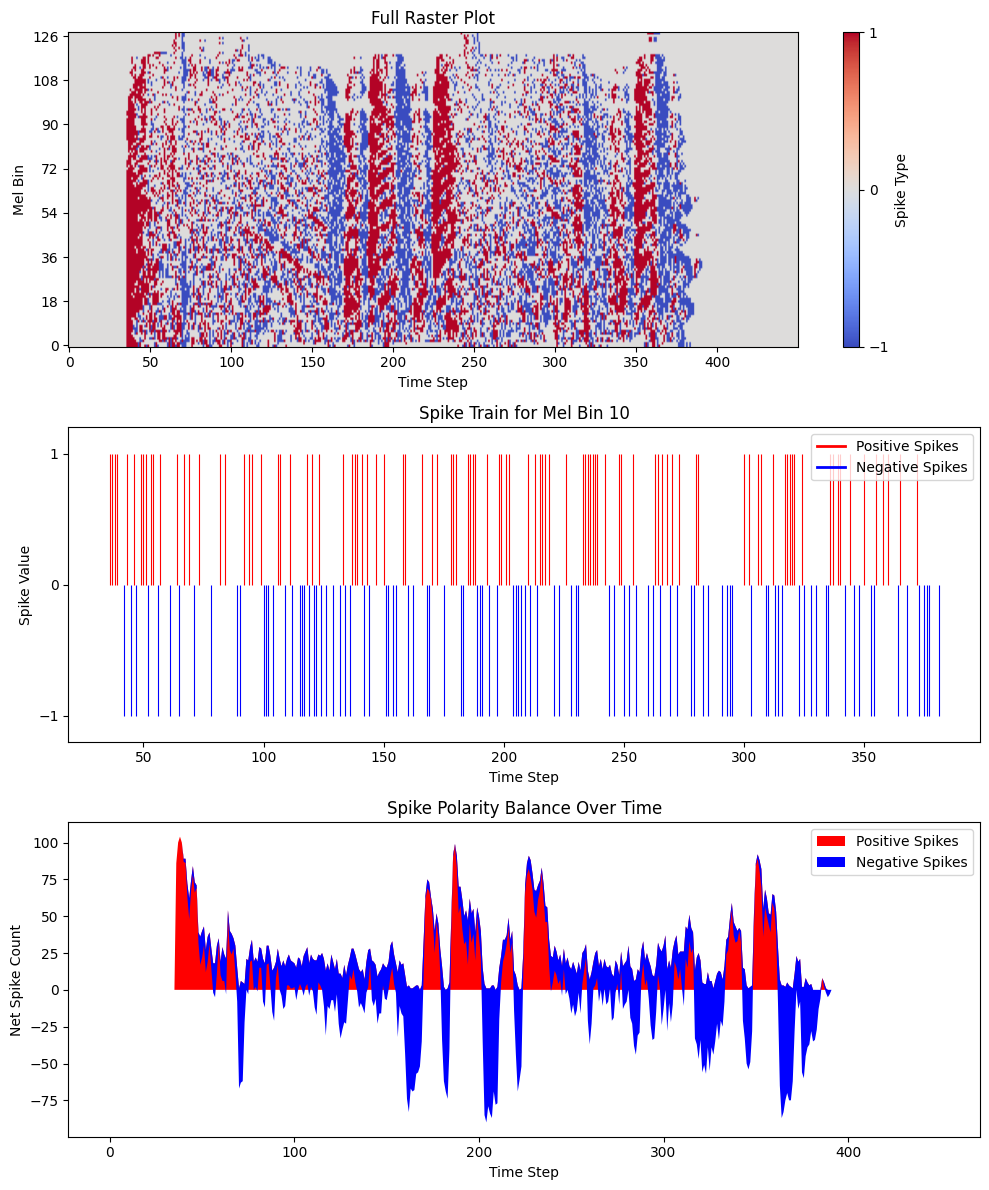

TAE Class: crying_baby


In [64]:
sample_idx = 10
visualize_spike_trains(spike_tensor=tae_x_batch, sample_idx=sample_idx, mel_bin=10)
print(f"TAE Class: {ESCLabels(tae_y_batch[sample_idx].item()).name}")

## Spike frequency comparison across encodings

In [100]:
def analyze_spike_density(dataloader, encoding_name):
    """Analyze spike density statistics for a given encoding method"""
    total_spikes = []
    total_samples = 0

    for batch_x, batch_y in dataloader:
        # Count non-zero spikes in each sample
        batch_spikes = batch_x.abs().sum(dim=[1, 2]).cpu().numpy()
        total_spikes.extend(batch_spikes)
        total_samples += len(batch_spikes)

        if total_samples >= 100:  # Analyze first 100 samples for quick comparison
            break

    total_spikes = np.array(total_spikes)

    print(f"\n{encoding_name} Spike Density Analysis:")
    print(f"  Mean spikes per sample: {np.mean(total_spikes):.2f}")
    print(f"  Std spikes per sample: {np.std(total_spikes):.2f}")
    print(f"  Min spikes: {np.min(total_spikes)}")
    print(f"  Max spikes: {np.max(total_spikes)}")
    print(f"  Median spikes: {np.median(total_spikes):.2f}")

    return total_spikes

# Analyze spike densities for all three encodings
print("="*50)
print("SPIKE DENSITY COMPARISON")
print("="*50)

delta_spikes = analyze_spike_density(delta_train_dataloader, "Delta Modulation")
mw_spikes = analyze_spike_density(mw_train_dataloader, "Moving Window")
tae_spikes = analyze_spike_density(tae_train_dataloader, "Threshold Adaptive")

# Plot comparison
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.hist(delta_spikes, bins=30, alpha=0.7, label='Delta', color='blue')
plt.title('Delta Modulation Spike Distribution')
plt.xlabel('Spikes per sample')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.hist(mw_spikes, bins=30, alpha=0.7, label='Moving Window', color='green')
plt.title('Moving Window Spike Distribution')
plt.xlabel('Spikes per sample')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
plt.hist(tae_spikes, bins=30, alpha=0.7, label='TAE', color='red')
plt.title('Threshold Based Representation Spike Distribution')
plt.xlabel('Spikes per sample')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
plt.hist([delta_spikes, mw_spikes, tae_spikes], bins=30, alpha=0.6,
         label=['Delta', 'Moving Window', 'TAE'], color=['blue', 'green', 'red'])
plt.title('All Encodings Comparison')
plt.xlabel('Spikes per sample')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

print("\nThreshold Based Representation implementation completed!")

SPIKE DENSITY COMPARISON

Delta Modulation Spike Density Analysis:
  Mean spikes per sample: 6448.52
  Std spikes per sample: 2754.76
  Min spikes: 919.0
  Max spikes: 15089.0
  Median spikes: 6138.00


NameError: name 'mw_train_dataloader' is not defined

# SNN Modelling

A single batch of data has shape: \[batch_size, time_frames, n_mels\].

In [149]:
class SNNClassifier(torch.nn.Module):
    def __init__(
        self,
        n_mels,
        hidden_sizes,
        num_classes,
        surr_grad,
        learn_thr=True,
        learn_beta=True,
    ):
        super(SNNClassifier, self).__init__()
        self.n_mels = n_mels
        self.hidden_sizes = hidden_sizes
        self.num_classes = num_classes
        self.surr_grad = surr_grad
        self.learn_thr = learn_thr
        self.learn_beta = learn_beta

        # Layer 1: Input to Hidden 1
        self.fc1 = torch.nn.Linear(n_mels, self.hidden_sizes[0])
        self.lif1 = snn.Leaky(
            beta=torch.full((self.hidden_sizes[0],), 0.5),
            learn_beta=learn_beta,
            learn_threshold=learn_thr,
            spike_grad=surr_grad,
            reset_mechanism="zero",
        )

        # Layer 2: Hidden 1 to Hidden 2
        self.fc2 = torch.nn.Linear(self.hidden_sizes[0], self.hidden_sizes[1])
        self.lif2 = snn.Leaky(
            beta=torch.full((self.hidden_sizes[1],), 0.5),
            learn_beta=learn_beta,
            learn_threshold=learn_thr,
            spike_grad=surr_grad,
            reset_mechanism="zero",
        )

        # Layer 3: Hidden 2 to Hidden 3
        self.fc3 = torch.nn.Linear(self.hidden_sizes[1], self.hidden_sizes[2])
        self.lif3 = snn.Leaky(
            beta=torch.full((self.hidden_sizes[2],), 0.5),
            learn_beta=learn_beta,
            learn_threshold=learn_thr,
            spike_grad=surr_grad,
            reset_mechanism="zero",
        )

        # Output Layer
        self.fc_out = torch.nn.Linear(self.hidden_sizes[2], num_classes)
        self.lif_out = snn.Leaky(
            beta=torch.full((num_classes,), 0.5),
            learn_beta=learn_beta,
            learn_threshold=learn_thr,
            spike_grad=surr_grad,
            reset_mechanism='none',
        )

    def forward(self, x):
        batch_size, time_steps, _ = x.shape

        # Initialize membrane potentials
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        mem_out = self.lif_out.init_leaky()

        spk_rec = []
        mem_rec = []

        for step in range(time_steps):
            x_t = x[:, step, :]

            cur1 = self.fc1(x_t)
            spk1, mem1 = self.lif1(cur1, mem1)

            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            cur3 = self.fc3(spk2)
            spk3, mem3 = self.lif3(cur3, mem3)

            cur_out = self.fc_out(spk3)
            spk_out, mem_out = self.lif_out(cur_out, mem_out)

            spk_rec.append(spk_out)
            mem_rec.append(mem_out)

        return torch.stack(spk_rec, dim=0), torch.stack(mem_rec, dim=0)


## DeltaModulation Training

In [150]:
hidden_sizes = [128, 128, 128]
num_classes = 10

snn_classifier = SNNClassifier(
    n_mels=N_MELS,
    hidden_sizes=hidden_sizes,
    num_classes=num_classes,
    surr_grad=snn.surrogate.fast_sigmoid(),
    learn_thr=True,
    learn_beta=True
).to(device)

summary(snn_classifier, input_size=(32, 1, N_MELS))

Layer (type:depth-idx)                   Output Shape              Param #
SNNClassifier                            [1, 32, 10]               --
├─Linear: 1-1                            [32, 128]                 16,512
├─Leaky: 1-2                             [32, 128]                 129
├─Linear: 1-3                            [32, 128]                 16,512
├─Leaky: 1-4                             [32, 128]                 129
├─Linear: 1-5                            [32, 128]                 16,512
├─Leaky: 1-6                             [32, 128]                 129
├─Linear: 1-7                            [32, 10]                  1,290
├─Leaky: 1-8                             [32, 10]                  11
Total params: 51,224
Trainable params: 51,224
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.63
Input size (MB): 0.02
Forward/backward pass size (MB): 0.20
Params size (MB): 0.20
Estimated Total Size (MB): 0.42

In [151]:
def train_fn(model, train_loader, valid_loader, accuracy, loss_fn, optimizer,
             epochs, patience, path, verbose=True, max_batches=None):
    """
    Optimized training function with:
    - Mixed precision training
    - Reduced GPU memory usage
    - Progress tracking
    """
    train_loss_list, val_loss_list = [], []
    train_acc_list, val_acc_list = [], []
    counter = 0
    best_val_loss = float('inf')

    # Enable mixed precision training if available
    scaler = torch.amp.GradScaler() if torch.cuda.is_available() else None

    for epoch in tqdm(range(epochs), desc="Epochs"):
        start_time = time.time()

        # Training mode
        model.train()
        train_loss, train_acc = 0.0, 0.0

        for batch_idx, (X, y) in enumerate(tqdm(train_loader, desc="Train batches", leave=False, total=len(train_loader))):
            X = X.squeeze().to(device)
            y = y.squeeze().long().to(device)

            optimizer.zero_grad(set_to_none=True)

            # Use mixed precision where available
            if scaler:
                with torch.cuda.amp.autocast():
                    spk_out, _ = model(X.float())
                    acc = accuracy(spk_out, y)
                    loss = loss_fn(spk_out, y)

                # Scale gradients and optimize
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                spk_out, _ = model(X.float())
                acc = accuracy(spk_out, y)
                loss = loss_fn(spk_out, y)
                loss.backward()
                optimizer.step()

            train_acc += acc.item()
            train_loss += loss.item()

            # Free up memory
            del X, y, spk_out, loss, acc

        # Calculate average metrics
        train_loss_avg = train_loss / len(train_loader)
        train_acc_avg = train_acc / len(train_loader)
        train_loss_list.append(train_loss_avg)
        train_acc_list.append(train_acc_avg)

        # Validation phase
        model.eval()
        val_loss, val_acc = 0.0, 0.0

        with torch.no_grad():
            for batch_idx, (X, y) in enumerate(valid_loader):
                X = X.squeeze().to(device)
                y = y.squeeze().long().to(device)

                # Forward pass with reduced memory usage
                if scaler:
                    with torch.cuda.amp.autocast():
                        spk_out, _ = model(X.float())
                        acc = accuracy(spk_out, y)
                        loss = loss_fn(spk_out, y)
                else:
                    spk_out, _ = model(X.float())
                    acc = accuracy(spk_out, y)
                    loss = loss_fn(spk_out, y)

                val_acc += acc.item()
                val_loss += loss.item()

                # Free up memory
                del X, y, spk_out, loss, acc

        # Calculate validation metrics
        val_loss_avg = val_loss / len(valid_loader)
        val_acc_avg = val_acc / len(valid_loader)
        val_loss_list.append(val_loss_avg)
        val_acc_list.append(val_acc_avg)

        # Early stopping logic
        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
            counter = 0
            if path:
                #torch.save(model.state_dict(), path)
                pass
        else:
            counter += 1

        if counter >= patience:
            print("Early stopping triggered")
            break

        torch.cuda.empty_cache()
        end_time = time.time()

        if verbose:
            print(f"\nEpoch {epoch+1}/{epochs} - {int(end_time-start_time)}s - "
                  f"loss: {train_loss_avg:.4f} - acc: {train_acc_avg:.4f} - "
                  f"val_loss: {val_loss_avg:.4f} - val_acc: {val_acc_avg:.4f}")

    return train_loss_list, train_acc_list, val_loss_list, val_acc_list

In [152]:
num_epochs = 100
patience = 25
optimizer = torch.optim.Adam(snn_classifier.parameters(), lr=0.001)

train_loss, train_acc, val_loss, val_acc = train_fn(
    model=snn_classifier,
    train_loader=delta_train_dataloader,
    valid_loader=delta_val_dataloader,
    accuracy=SF.acc.accuracy_rate,
    loss_fn=snn.functional.ce_count_loss(),
    optimizer=optimizer,
    epochs=num_epochs,
    patience=patience,
    path="./",
    verbose=True,
)

Epochs:   1%|          | 1/100 [00:54<1:29:49, 54.44s/it]


Epoch 1/100 - 54s - loss: 2.3026 - acc: 0.0997 - val_loss: 2.3026 - val_acc: 0.1004



Epochs:   2%|▏         | 2/100 [01:45<1:25:43, 52.49s/it]


Epoch 2/100 - 51s - loss: 2.3026 - acc: 0.1009 - val_loss: 2.3026 - val_acc: 0.1004



Epochs:   3%|▎         | 3/100 [02:35<1:23:01, 51.36s/it]


Epoch 3/100 - 50s - loss: 2.3012 - acc: 0.1065 - val_loss: 2.3107 - val_acc: 0.1004



Epochs:   4%|▍         | 4/100 [03:25<1:21:31, 50.95s/it]


Epoch 4/100 - 50s - loss: 2.3296 - acc: 0.1236 - val_loss: 2.3026 - val_acc: 0.1004



Epochs:   5%|▌         | 5/100 [04:13<1:18:49, 49.79s/it]


Epoch 5/100 - 47s - loss: 2.2953 - acc: 0.1288 - val_loss: 2.3317 - val_acc: 0.1183



Epochs:   6%|▌         | 6/100 [05:03<1:18:04, 49.83s/it]


Epoch 6/100 - 49s - loss: 2.3357 - acc: 0.1387 - val_loss: 2.2743 - val_acc: 0.1518



Epochs:   7%|▋         | 7/100 [05:52<1:16:46, 49.53s/it]


Epoch 7/100 - 48s - loss: 2.2947 - acc: 0.1783 - val_loss: 2.1417 - val_acc: 0.2344



Epochs:   8%|▊         | 8/100 [06:40<1:15:24, 49.18s/it]


Epoch 8/100 - 48s - loss: 2.7053 - acc: 0.2285 - val_loss: 2.1829 - val_acc: 0.2054



Epochs:   9%|▉         | 9/100 [07:29<1:14:26, 49.08s/it]


Epoch 9/100 - 48s - loss: 2.4773 - acc: 0.2138 - val_loss: 2.3799 - val_acc: 0.1987



Epochs:  10%|█         | 10/100 [08:17<1:12:55, 48.62s/it]


Epoch 10/100 - 47s - loss: 2.3640 - acc: 0.2711 - val_loss: 3.0451 - val_acc: 0.2835



Epochs:  11%|█         | 11/100 [09:05<1:11:57, 48.51s/it]


Epoch 11/100 - 48s - loss: 2.5065 - acc: 0.2978 - val_loss: 2.0443 - val_acc: 0.2991



Epochs:  12%|█▏        | 12/100 [09:54<1:11:19, 48.63s/it]


Epoch 12/100 - 48s - loss: 2.2202 - acc: 0.3364 - val_loss: 1.9986 - val_acc: 0.4196



Epochs:  13%|█▎        | 13/100 [10:43<1:10:32, 48.65s/it]


Epoch 13/100 - 48s - loss: 1.9844 - acc: 0.3918 - val_loss: 1.7898 - val_acc: 0.4375



Epochs:  14%|█▍        | 14/100 [11:31<1:09:32, 48.51s/it]


Epoch 14/100 - 48s - loss: 1.7826 - acc: 0.4581 - val_loss: 1.9130 - val_acc: 0.3929



Epochs:  15%|█▌        | 15/100 [12:20<1:09:04, 48.76s/it]


Epoch 15/100 - 49s - loss: 1.8399 - acc: 0.4427 - val_loss: 1.5022 - val_acc: 0.4554



Epochs:  16%|█▌        | 16/100 [13:08<1:07:48, 48.43s/it]


Epoch 16/100 - 47s - loss: 1.8342 - acc: 0.4588 - val_loss: 2.1700 - val_acc: 0.4308



Epochs:  17%|█▋        | 17/100 [13:57<1:07:19, 48.67s/it]


Epoch 17/100 - 49s - loss: 1.8136 - acc: 0.4766 - val_loss: 1.5650 - val_acc: 0.4487



Epochs:  18%|█▊        | 18/100 [14:45<1:06:11, 48.44s/it]


Epoch 18/100 - 47s - loss: 1.6618 - acc: 0.4988 - val_loss: 1.5583 - val_acc: 0.4665



Epochs:  19%|█▉        | 19/100 [15:36<1:06:30, 49.26s/it]


Epoch 19/100 - 51s - loss: 1.6060 - acc: 0.5253 - val_loss: 1.6668 - val_acc: 0.5022



Epochs:  20%|██        | 20/100 [16:27<1:06:06, 49.58s/it]


Epoch 20/100 - 50s - loss: 1.5305 - acc: 0.5182 - val_loss: 1.4599 - val_acc: 0.4710



Epochs:  21%|██        | 21/100 [17:15<1:04:53, 49.28s/it]


Epoch 21/100 - 48s - loss: 1.4429 - acc: 0.5504 - val_loss: 1.9183 - val_acc: 0.4554



Epochs:  22%|██▏       | 22/100 [18:04<1:04:00, 49.24s/it]


Epoch 22/100 - 49s - loss: 1.3657 - acc: 0.5606 - val_loss: 1.2767 - val_acc: 0.6049



Epochs:  23%|██▎       | 23/100 [18:53<1:02:57, 49.06s/it]


Epoch 23/100 - 48s - loss: 1.3254 - acc: 0.5926 - val_loss: 1.8853 - val_acc: 0.4866



Epochs:  24%|██▍       | 24/100 [19:41<1:01:48, 48.80s/it]


Epoch 24/100 - 48s - loss: 1.2678 - acc: 0.6250 - val_loss: 1.7860 - val_acc: 0.5670



Epochs:  25%|██▌       | 25/100 [20:31<1:01:16, 49.02s/it]


Epoch 25/100 - 49s - loss: 1.5166 - acc: 0.6151 - val_loss: 2.0115 - val_acc: 0.5134



Epochs:  26%|██▌       | 26/100 [21:19<1:00:10, 48.79s/it]


Epoch 26/100 - 48s - loss: 1.5233 - acc: 0.6108 - val_loss: 2.0373 - val_acc: 0.5290



Epochs:  27%|██▋       | 27/100 [22:10<1:00:06, 49.40s/it]


Epoch 27/100 - 50s - loss: 1.4998 - acc: 0.6264 - val_loss: 1.6988 - val_acc: 0.5670



Epochs:  28%|██▊       | 28/100 [22:58<58:50, 49.03s/it]  


Epoch 28/100 - 48s - loss: 1.2689 - acc: 0.6641 - val_loss: 2.1249 - val_acc: 0.5223



Epochs:  29%|██▉       | 29/100 [23:47<58:07, 49.12s/it]


Epoch 29/100 - 49s - loss: 1.1645 - acc: 0.6873 - val_loss: 1.6940 - val_acc: 0.5469



Epochs:  30%|███       | 30/100 [24:36<57:04, 48.92s/it]


Epoch 30/100 - 48s - loss: 1.0650 - acc: 0.7195 - val_loss: 1.6467 - val_acc: 0.6384



Epochs:  31%|███       | 31/100 [25:24<55:55, 48.63s/it]


Epoch 31/100 - 47s - loss: 1.0913 - acc: 0.7173 - val_loss: 1.7956 - val_acc: 0.5670



Epochs:  32%|███▏      | 32/100 [26:14<55:33, 49.02s/it]


Epoch 32/100 - 49s - loss: 0.9078 - acc: 0.7545 - val_loss: 1.5054 - val_acc: 0.6696



Epochs:  33%|███▎      | 33/100 [27:02<54:35, 48.89s/it]


Epoch 33/100 - 48s - loss: 0.9782 - acc: 0.7346 - val_loss: 1.3989 - val_acc: 0.6696



Epochs:  34%|███▍      | 34/100 [27:53<54:18, 49.36s/it]


Epoch 34/100 - 50s - loss: 1.0048 - acc: 0.7379 - val_loss: 1.6174 - val_acc: 0.5670



Epochs:  35%|███▌      | 35/100 [28:43<53:40, 49.54s/it]


Epoch 35/100 - 49s - loss: 0.8337 - acc: 0.7621 - val_loss: 1.6756 - val_acc: 0.5312



Epochs:  36%|███▌      | 36/100 [29:33<53:16, 49.95s/it]


Epoch 36/100 - 50s - loss: 0.8119 - acc: 0.7846 - val_loss: 1.8819 - val_acc: 0.6161



Epochs:  37%|███▋      | 37/100 [30:22<51:58, 49.50s/it]


Epoch 37/100 - 48s - loss: 0.7885 - acc: 0.7971 - val_loss: 1.5968 - val_acc: 0.6741



Epochs:  38%|███▊      | 38/100 [31:11<51:04, 49.42s/it]


Epoch 38/100 - 49s - loss: 0.8213 - acc: 0.7834 - val_loss: 1.7931 - val_acc: 0.6540



Epochs:  39%|███▉      | 39/100 [32:01<50:16, 49.45s/it]


Epoch 39/100 - 49s - loss: 0.8438 - acc: 0.7893 - val_loss: 2.1985 - val_acc: 0.6138



Epochs:  40%|████      | 40/100 [32:49<49:01, 49.03s/it]


Epoch 40/100 - 48s - loss: 0.7591 - acc: 0.8108 - val_loss: 1.6349 - val_acc: 0.7210



Epochs:  41%|████      | 41/100 [33:39<48:27, 49.27s/it]


Epoch 41/100 - 49s - loss: 0.6672 - acc: 0.8338 - val_loss: 1.8994 - val_acc: 0.4866



Epochs:  42%|████▏     | 42/100 [34:27<47:25, 49.06s/it]


Epoch 42/100 - 48s - loss: 0.8141 - acc: 0.7971 - val_loss: 2.0338 - val_acc: 0.6116



Epochs:  43%|████▎     | 43/100 [35:16<46:42, 49.16s/it]


Epoch 43/100 - 49s - loss: 0.6722 - acc: 0.8198 - val_loss: 2.4317 - val_acc: 0.6161



Epochs:  44%|████▍     | 44/100 [36:05<45:48, 49.08s/it]


Epoch 44/100 - 48s - loss: 0.5994 - acc: 0.8376 - val_loss: 1.9161 - val_acc: 0.6317



Epochs:  45%|████▌     | 45/100 [36:56<45:23, 49.52s/it]


Epoch 45/100 - 50s - loss: 0.6039 - acc: 0.8359 - val_loss: 1.6188 - val_acc: 0.5982



Epochs:  46%|████▌     | 46/100 [37:45<44:34, 49.52s/it]


Epoch 46/100 - 49s - loss: 0.5021 - acc: 0.8613 - val_loss: 1.7145 - val_acc: 0.6295



Epochs:  46%|████▌     | 46/100 [38:34<45:17, 50.32s/it]

Early stopping triggered


In [153]:
print(train_loss[-1], train_acc[-1] * 100, val_loss[-1], val_acc[-1] * 100)

0.5752644400027666 85.58238636363636 2.9790056943893433 55.13392857142857


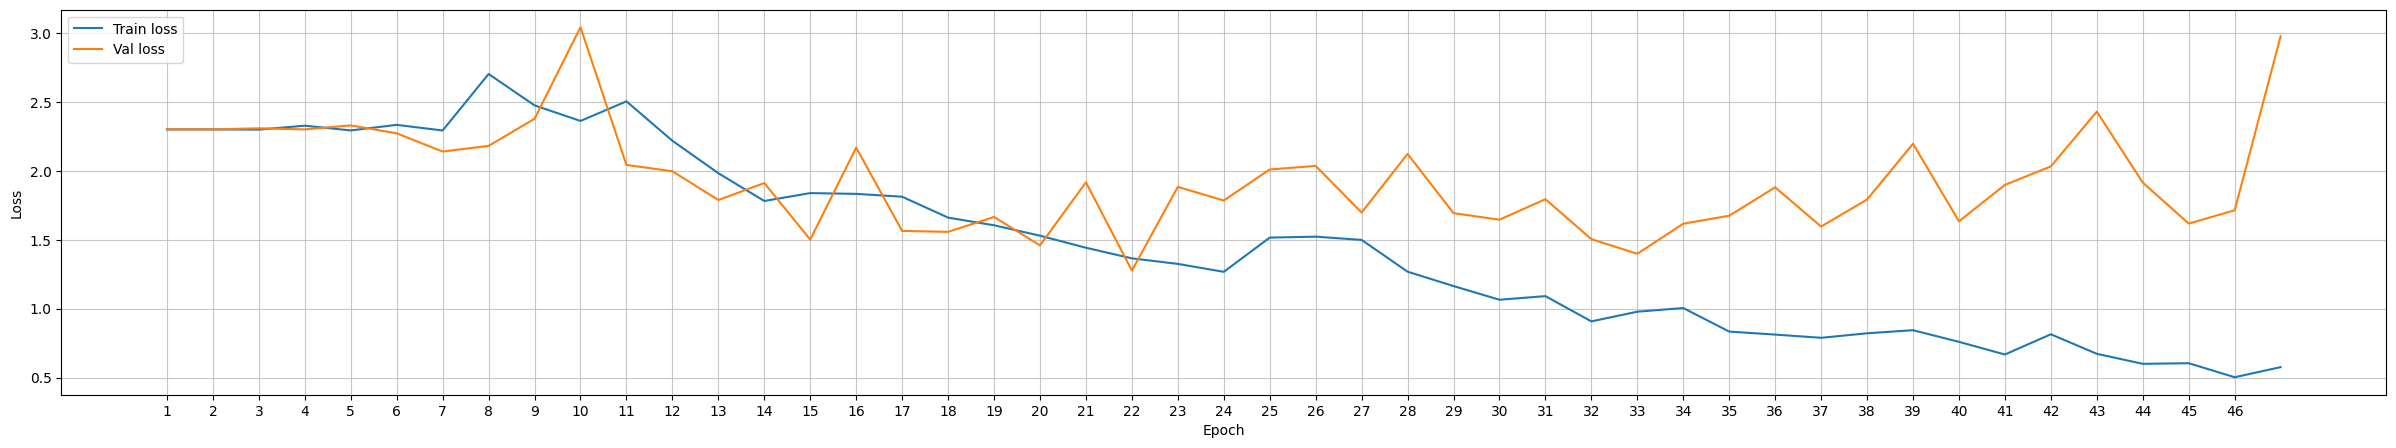

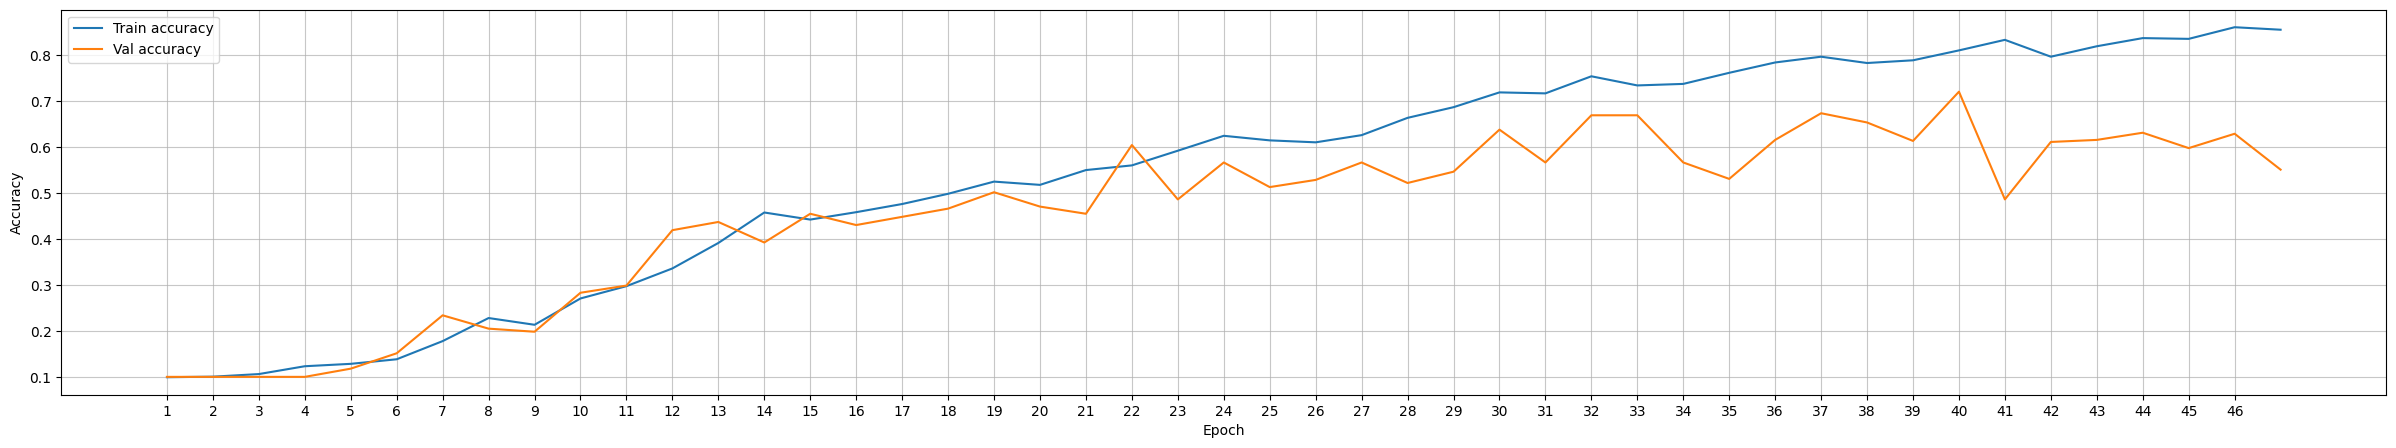

In [154]:
# Plot loss
plt.figure(figsize=(30,5))
plt.plot(np.arange(1, len(train_loss)+1), train_loss, label='Train loss')
plt.plot(np.arange(1, len(train_loss)+1), val_loss, label='Val loss')
plt.xticks(np.arange(1, len(train_loss)))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=.7)
plt.legend()

# Plot accuracy
plt.figure(figsize=(30,5))
plt.plot(np.arange(1, len(train_acc)+1), train_acc, label='Train accuracy')
plt.plot(np.arange(1, len(train_acc)+1), val_acc, label='Val accuracy')
plt.xticks(np.arange(1, len(train_acc)))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(alpha=.7)
plt.legend()
plt.show()

FINAL EVALUATION - DELTA MODULATION SNN
COMPREHENSIVE EVALUATION RESULTS
Accuracy: 0.6000 (60.00%)

MACRO AVERAGES:
  F1-Score   : 0.5866
  Precision  : 0.6505
  Recall     : 0.6000

WEIGHTED AVERAGES:
  F1-Score   : 0.5866
  Precision  : 0.6505
  Recall     : 0.6000

PER-CLASS METRICS:
------------------------------------------------------------
Class           F1       Precision  Recall  
------------------------------------------------------------
chainsaw        0.7143   0.6250     0.8333  
clock_tick      0.7143   0.6250     0.8333  
crackling_fire  0.8000   1.0000     0.6667  
crying_baby     0.7273   0.8000     0.6667  
dog             0.5000   1.0000     0.3333  
helicopter      0.5882   0.4545     0.8333  
rain            0.5000   0.5000     0.5000  
rooster         0.5000   0.5000     0.5000  
sea_waves       0.2500   0.5000     0.1667  
sneezing        0.5714   0.5000     0.6667  

DETAILED CLASSIFICATION REPORT
                precision    recall  f1-score   support

      

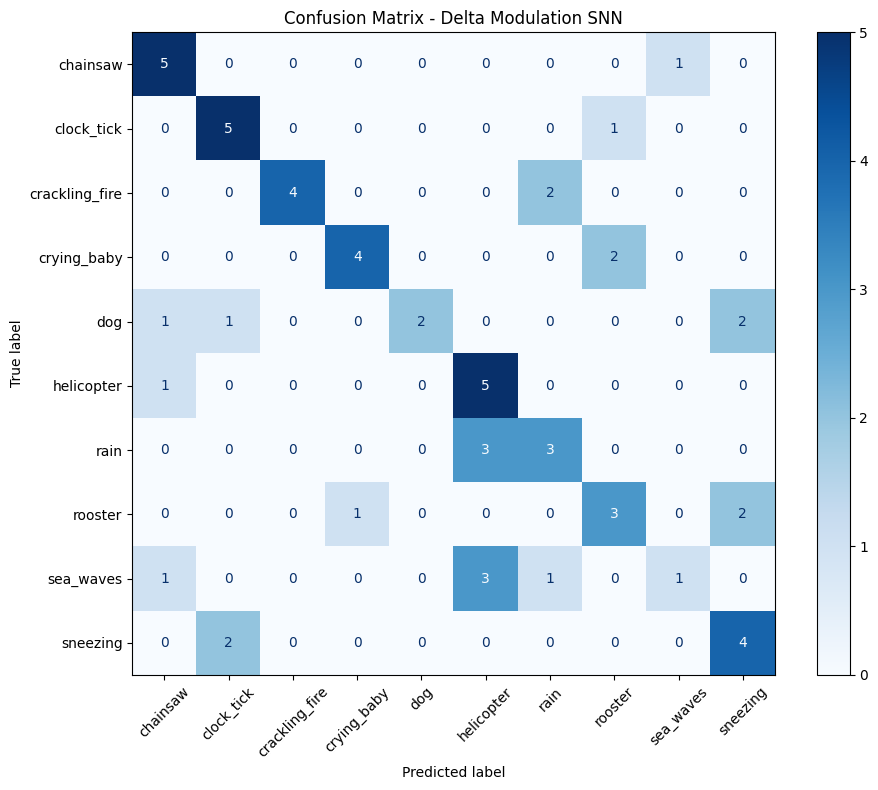

In [155]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score, precision_score, recall_score

def evaluate_model_comprehensive(model, dataloader, class_names, device):
    """
    Comprehensive evaluation function that computes accuracy, F1, precision, and recall.
    Now handles zero-division gracefully and reports classes with no predictions.
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in dataloader:
            X = X.squeeze().to(device)
            y = y.squeeze().long().to(device)

            spk_out, _ = model(X.float())
            spk_sum = spk_out.sum(dim=0)  # [batch_size, num_classes]
            preds = torch.argmax(spk_sum, dim=1)

            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())

    # Concatenate all batches
    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    # Identify classes never predicted
    missing = set(range(len(class_names))) - set(np.unique(all_preds))
    if missing:
        print("WARNING: The following classes were never predicted:",
              [class_names[i] for i in sorted(missing)])

    # Calculate accuracy
    accuracy = (all_preds == all_labels).mean()

    # Macro and weighted metrics with zero_division=0
    f1_macro    = f1_score(all_labels, all_preds, average='macro',    zero_division=0)
    f1_weighted = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    precision_macro    = precision_score(all_labels, all_preds, average='macro',    zero_division=0)
    precision_weighted = precision_score(all_labels, all_preds, average='weighted', zero_division=0)

    recall_macro    = recall_score(all_labels, all_preds, average='macro',    zero_division=0)
    recall_weighted = recall_score(all_labels, all_preds, average='weighted', zero_division=0)

    # Per-class metrics
    f1_per_class        = f1_score(all_labels, all_preds, average=None, zero_division=0)
    precision_per_class = precision_score(all_labels, all_preds, average=None, zero_division=0)
    recall_per_class    = recall_score(all_labels, all_preds, average=None, zero_division=0)

    # Print summary
    print("="*60)
    print("COMPREHENSIVE EVALUATION RESULTS")
    print("="*60)
    print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)\n")

    print("MACRO AVERAGES:")
    print(f"  F1-Score   : {f1_macro:.4f}")
    print(f"  Precision  : {precision_macro:.4f}")
    print(f"  Recall     : {recall_macro:.4f}\n")

    print("WEIGHTED AVERAGES:")
    print(f"  F1-Score   : {f1_weighted:.4f}")
    print(f"  Precision  : {precision_weighted:.4f}")
    print(f"  Recall     : {recall_weighted:.4f}\n")

    print("PER-CLASS METRICS:")
    print("-" * 60)
    print(f"{'Class':<15} {'F1':<8} {'Precision':<10} {'Recall':<8}")
    print("-" * 60)
    for i, name in enumerate(class_names):
        print(f"{name:<15} "
              f"{f1_per_class[i]:<8.4f} "
              f"{precision_per_class[i]:<10.4f} "
              f"{recall_per_class[i]:<8.4f}")

    # Detailed report
    print("\n" + "="*60)
    print("DETAILED CLASSIFICATION REPORT")
    print("="*60)
    print(classification_report(
        all_labels,
        all_preds,
        target_names=class_names,
        digits=4,
        zero_division=0
    ))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
    plt.title("Confusion Matrix - Delta Modulation SNN")
    plt.tight_layout()
    plt.show()

    return {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'precision_macro': precision_macro,
        'precision_weighted': precision_weighted,
        'recall_macro': recall_macro,
        'recall_weighted': recall_weighted,
        'f1_per_class': f1_per_class,
        'precision_per_class': precision_per_class,
        'recall_per_class': recall_per_class,
        'confusion_matrix': cm
    }

print("FINAL EVALUATION - DELTA MODULATION SNN")
print("="*80)

class_names = [
    'chainsaw', 'clock_tick', 'crackling_fire', 'crying_baby', 'dog',
    'helicopter', 'rain', 'rooster', 'sea_waves', 'sneezing'
]

# Comprehensive evaluation on test set
delta_results = evaluate_model_comprehensive(
    model=snn_classifier,
    dataloader=delta_test_dataloader,
    class_names=class_names,
    device=device
)

## Moving Window Training

In [ ]:
patience = 40
num_epochs = 100
optimizer = torch.optim.Adam(snn_classifier.parameters(), lr=0.001)

train_loss, train_acc, val_loss, val_acc = train_fn(
    model=snn_classifier,
    train_loader=mw_train_dataloader,
    valid_loader=mw_val_dataloader,
    accuracy=SF.acc.accuracy_rate,
    loss_fn=snn.functional.ce_count_loss(),
    optimizer=optimizer,
    epochs=num_epochs,
    patience=patience,
    path="./",
    verbose=True,
)

Train batches:   0%|          | 0/9 [00:00<?, ?it/s]<ipython-input-60-8837a4e07bdc>:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():

Train batches: 100%|██████████| 9/9 [02:36<00:00, 13.19s/it]
                                                            <ipython-input-60-8837a4e07bdc>:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epochs:   1%|          | 1/100 [03:08<5:11:20, 188.69s/it]


Epoch 1/100 - 188s - loss: 2.3026 - acc: 0.0984 - val_loss: 2.3026 - val_acc: 0.1004



Epochs:   2%|▏         | 2/100 [06:14<5:05:05, 186.80s/it]


Epoch 2/100 - 185s - loss: 2.3026 - acc: 0.0984 - val_loss: 2.3026 - val_acc: 0.1004



Epochs:   3%|▎         | 3/100 [09:20<5:01:37, 186.57s/it]


Epoch 3/100 - 186s - loss: 2.3026 - acc: 0.0995 - val_loss: 2.3026 - val_acc: 0.1004



Epochs:   4%|▍         | 4/100 [12:26<4:58:24, 186.50s/it]


Epoch 4/100 - 186s - loss: 2.3026 - acc: 0.1019 - val_loss: 2.3026 - val_acc: 0.1004



Epochs:   5%|▌         | 5/100 [15:33<4:55:34, 186.68s/it]


Epoch 5/100 - 186s - loss: 2.3026 - acc: 0.0995 - val_loss: 2.3026 - val_acc: 0.1004



Epochs:   6%|▌         | 6/100 [18:39<4:52:00, 186.39s/it]


Epoch 6/100 - 185s - loss: 2.3026 - acc: 0.0995 - val_loss: 2.3026 - val_acc: 0.1004



Epochs:   7%|▋         | 7/100 [21:47<4:49:40, 186.89s/it]


Epoch 7/100 - 187s - loss: 2.3026 - acc: 0.0972 - val_loss: 2.3026 - val_acc: 0.1004



Epochs:   8%|▊         | 8/100 [24:54<4:46:31, 186.87s/it]


Epoch 8/100 - 186s - loss: 2.3026 - acc: 0.0995 - val_loss: 2.3026 - val_acc: 0.1004



Epochs:   9%|▉         | 9/100 [28:00<4:43:12, 186.73s/it]


Epoch 9/100 - 186s - loss: 2.3026 - acc: 0.1030 - val_loss: 2.3026 - val_acc: 0.1004



Epochs:  10%|█         | 10/100 [31:07<4:40:06, 186.74s/it]


Epoch 10/100 - 186s - loss: 2.3026 - acc: 0.1007 - val_loss: 2.3026 - val_acc: 0.1004



Epochs:  11%|█         | 11/100 [34:14<4:36:56, 186.70s/it]


Epoch 11/100 - 186s - loss: 2.3026 - acc: 0.0984 - val_loss: 2.3026 - val_acc: 0.1004



Epochs:  12%|█▏        | 12/100 [37:21<4:34:05, 186.88s/it]


Epoch 12/100 - 187s - loss: 2.3026 - acc: 0.1019 - val_loss: 2.3026 - val_acc: 0.1004



Epochs:  13%|█▎        | 13/100 [40:27<4:30:46, 186.74s/it]


Epoch 13/100 - 186s - loss: 2.3026 - acc: 0.1007 - val_loss: 2.3026 - val_acc: 0.1004



Epochs:  14%|█▍        | 14/100 [43:35<4:27:55, 186.92s/it]


Epoch 14/100 - 187s - loss: 2.3063 - acc: 0.1551 - val_loss: 2.3026 - val_acc: 0.1004



Epochs:  15%|█▌        | 15/100 [46:40<4:24:06, 186.43s/it]


Epoch 15/100 - 185s - loss: 2.2903 - acc: 0.1215 - val_loss: 2.2585 - val_acc: 0.1853



Epochs:  16%|█▌        | 16/100 [49:46<4:20:54, 186.36s/it]


Epoch 16/100 - 186s - loss: 2.2382 - acc: 0.1620 - val_loss: 2.1887 - val_acc: 0.1362



Epochs:  17%|█▋        | 17/100 [52:51<4:17:14, 185.95s/it]


Epoch 17/100 - 185s - loss: 2.1905 - acc: 0.1806 - val_loss: 2.1452 - val_acc: 0.2121



Epochs:  18%|█▊        | 18/100 [55:58<4:14:17, 186.07s/it]


Epoch 18/100 - 186s - loss: 2.1540 - acc: 0.1875 - val_loss: 2.1490 - val_acc: 0.1853



Epochs:  19%|█▉        | 19/100 [59:03<4:11:06, 186.00s/it]


Epoch 19/100 - 185s - loss: 2.2500 - acc: 0.1887 - val_loss: 2.2541 - val_acc: 0.1853



Epochs:  20%|██        | 20/100 [1:02:09<4:07:58, 185.98s/it]


Epoch 20/100 - 185s - loss: 2.2647 - acc: 0.1794 - val_loss: 2.3168 - val_acc: 0.1317



Epochs:  21%|██        | 21/100 [1:05:16<4:05:00, 186.08s/it]


Epoch 21/100 - 186s - loss: 2.1718 - acc: 0.2176 - val_loss: 2.1403 - val_acc: 0.1853



Epochs:  22%|██▏       | 22/100 [1:08:23<4:02:20, 186.42s/it]


Epoch 22/100 - 187s - loss: 2.1293 - acc: 0.2303 - val_loss: 2.4000 - val_acc: 0.2165



Epochs:  23%|██▎       | 23/100 [1:11:28<3:58:46, 186.06s/it]


Epoch 23/100 - 185s - loss: 2.1741 - acc: 0.2269 - val_loss: 2.3859 - val_acc: 0.1496



Epochs:  24%|██▍       | 24/100 [1:14:35<3:55:56, 186.27s/it]


Epoch 24/100 - 186s - loss: 2.1672 - acc: 0.1956 - val_loss: 2.0429 - val_acc: 0.2812



Epochs:  25%|██▌       | 25/100 [1:17:41<3:52:40, 186.14s/it]


Epoch 25/100 - 185s - loss: 2.0484 - acc: 0.2454 - val_loss: 2.0333 - val_acc: 0.2344



Epochs:  26%|██▌       | 26/100 [1:20:48<3:49:55, 186.42s/it]


Epoch 26/100 - 187s - loss: 2.0304 - acc: 0.2546 - val_loss: 2.1881 - val_acc: 0.2188



Epochs:  27%|██▋       | 27/100 [1:23:53<3:46:17, 185.99s/it]


Epoch 27/100 - 184s - loss: 2.0611 - acc: 0.2512 - val_loss: 2.1170 - val_acc: 0.2500



Epochs:  28%|██▊       | 28/100 [1:27:00<3:43:40, 186.40s/it]


Epoch 28/100 - 187s - loss: 2.1785 - acc: 0.2546 - val_loss: 2.2394 - val_acc: 0.2478



Epochs:  29%|██▉       | 29/100 [1:30:10<3:41:49, 187.46s/it]


Epoch 29/100 - 189s - loss: 2.0816 - acc: 0.2616 - val_loss: 1.9374 - val_acc: 0.3147



Epochs:  30%|███       | 30/100 [1:33:17<3:38:37, 187.40s/it]


Epoch 30/100 - 187s - loss: 2.0027 - acc: 0.2870 - val_loss: 1.9592 - val_acc: 0.2790



Epochs:  31%|███       | 31/100 [1:36:25<3:35:27, 187.36s/it]


Epoch 31/100 - 187s - loss: 5.8898 - acc: 0.2975 - val_loss: 12.0797 - val_acc: 0.2656



Epochs:  32%|███▏      | 32/100 [1:39:31<3:32:04, 187.13s/it]


Epoch 32/100 - 186s - loss: 7.2869 - acc: 0.3310 - val_loss: 1.9834 - val_acc: 0.2969



Epochs:  33%|███▎      | 33/100 [1:42:38<3:28:44, 186.93s/it]


Epoch 33/100 - 186s - loss: 2.4910 - acc: 0.3299 - val_loss: 2.1225 - val_acc: 0.3147



Epochs:  34%|███▍      | 34/100 [1:45:43<3:25:15, 186.60s/it]


Epoch 34/100 - 185s - loss: 1.9844 - acc: 0.3252 - val_loss: 2.0885 - val_acc: 0.2545



Epochs:  35%|███▌      | 35/100 [1:48:51<3:22:24, 186.84s/it]


Epoch 35/100 - 187s - loss: 2.5790 - acc: 0.3079 - val_loss: 2.0506 - val_acc: 0.3661



Epochs:  36%|███▌      | 36/100 [1:51:58<3:19:29, 187.02s/it]


Epoch 36/100 - 187s - loss: 2.4134 - acc: 0.3611 - val_loss: 2.0138 - val_acc: 0.3058



Epochs:  37%|███▋      | 37/100 [1:55:06<3:16:27, 187.10s/it]


Epoch 37/100 - 187s - loss: 2.0284 - acc: 0.3079 - val_loss: 1.9727 - val_acc: 0.3594



Epochs:  38%|███▊      | 38/100 [1:58:16<3:14:24, 188.13s/it]


Epoch 38/100 - 190s - loss: 1.9436 - acc: 0.3785 - val_loss: 2.3322 - val_acc: 0.2969



Epochs:  39%|███▉      | 39/100 [2:01:25<3:11:26, 188.31s/it]


Epoch 39/100 - 188s - loss: 2.0839 - acc: 0.3900 - val_loss: 2.7893 - val_acc: 0.3237



Epochs:  40%|████      | 40/100 [2:04:31<3:07:41, 187.69s/it]


Epoch 40/100 - 186s - loss: 2.0767 - acc: 0.4132 - val_loss: 2.8747 - val_acc: 0.3616



Epochs:  41%|████      | 41/100 [2:07:39<3:04:35, 187.71s/it]


Epoch 41/100 - 187s - loss: 2.0032 - acc: 0.4178 - val_loss: 2.5528 - val_acc: 0.2478



Epochs:  42%|████▏     | 42/100 [2:10:47<3:01:42, 187.98s/it]


Epoch 42/100 - 188s - loss: 1.8499 - acc: 0.4606 - val_loss: 2.6354 - val_acc: 0.5335



Train batches:  22%|██▏       | 2/9 [00:43<02:13, 19.05s/it]

In [ ]:
# Plot loss
plt.figure(figsize=(15,5))
plt.plot(np.arange(1, len(train_loss)+1), train_loss, label='Train loss')
plt.plot(np.arange(1, len(train_loss)+1), val_loss, label='Val loss')
plt.xticks(np.arange(1, len(train_loss)))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=.7)
plt.legend()

# Plot accuracy
plt.figure(figsize=(15,5))
plt.plot(np.arange(1, len(train_acc)+1), train_acc, label='Train accuracy')
plt.plot(np.arange(1, len(train_acc)+1), val_acc, label='Val accuracy')
plt.xticks(np.arange(1, len(train_acc)))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(alpha=.7)
plt.legend()
plt.show()

In [ ]:
evaluate_and_plot_confusion_matrix(snn_classifier, mw_test_dataloader, class_names)